In [1]:
# First, load the IPython extension for auto-reloading
%load_ext autoreload
%autoreload 2

import pickle
import torch
import sys
import os
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

from src.eval.evaluate_model import (
    evaluate_model,
    evaluate_by_hydrophone,
    evaluate_by_anomaly_type,
    plot_confusion_matrix,
    plot_example_spectrograms,
    plot_threshold_f1f2_curve,
    plot_all_false_positives,
    plot_all_false_negatives
)
from src.utilities.training_utils import create_model
from src.onc_dataset import ONCSpectrogramDataset
from src.models import AMBAModel
from torch.utils.data import DataLoader

/home/merileo/ssamba/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/merileo/ssamba/myenv/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/merileo/ssamba/myenv/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


VisionMamba imported successfully
RMSNorm imported successfully


In [2]:
# Path to your model directory
model_dir = Path("/scratch/merileo/exp/amba-base-f16-t16-b16-lr1e-4-m300-custom-tr0.8-exp1")
checkpoint_path = str(model_dir / "models/ft-cls_best_checkpoint.pth")

# Load the saved args
with open(model_dir / "args.pkl", "rb") as f:
    args = pickle.load(f)

# Create and load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model(args)
model = model.to(device)

# Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)
if 'model_state_dict' in checkpoint:
    state_dict = checkpoint['model_state_dict']
else:
    state_dict = checkpoint

model.load_state_dict(state_dict)

Models directory: /scratch/merileo/exp/amba-base-f16-t16-b16-lr1e-4-m300-custom-tr0.8-exp1/models
Found pretrained checkpoint: pretrain-joint_best_checkpoint.pth
Vision Mamba Config: {'img_size': (512, 512), 'patch_size': 16, 'stride': 16, 'embed_dim': 768, 'depth': 24, 'channels': 1, 'num_classes': 2, 'drop_rate': 0.0, 'drop_path_rate': 0.1, 'norm_epsilon': 1e-05, 'rms_norm': False, 'residual_in_fp32': False, 'fused_add_norm': False, 'if_rope': False, 'if_rope_residual': False, 'bimamba_type': 'v2', 'if_cls_token': True, 'if_devide_out': True, 'use_double_cls_token': False, 'use_middle_cls_token': False, 'if_bidirectional': True, 'final_pool_type': 'none', 'if_abs_pos_embed': True, 'if_bimamba': False}
Loading pretrained model from: /scratch/merileo/exp/amba-base-f16-t16-b16-lr1e-4-m300-custom-tr0.8-exp1/models/pretrain-joint_best_checkpoint.pth
Loaded state dict keys: dict_keys(['epoch', 'global_step', 'model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict', 'best_metrics'

<All keys matched successfully>

In [3]:
# Load the test data
data_path = '/scratch/merileo/different_locations_incl_backgroundpipelinenormals_multilabel.h5'

# Create test dataset using the same args that were used during training
test_dataset = ONCSpectrogramDataset(
    data_path=data_path,  # or args.data_eval if you used a separate test set
    split='test',
    train_ratio=args.train_ratio,
    val_ratio=args.val_ratio,
    seed=args.split_seed if hasattr(args, 'split_seed') else 42,
    target_length=args.target_length,
    num_mel_bins=args.num_mel_bins,
    supervised=True,
    dataset_mean=args.dataset_mean,
    dataset_std=args.dataset_std,
    subsample_test=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=args.batch_size,
    shuffle=False,
    num_workers=4
)


[DEBUG] Found 'sources' dataset in HDF5 file with shape (16500,)
[DEBUG] First few sources: [b'ICLISTENHF1951_20240902T173038.996Z_20240902T173538.996Z-spect_plotRes.mat'
 b'ICLISTENHF1951_20240902T173447.989Z_20240902T173947.989Z-spect_plotRes.mat'
 b'ICLISTENHF1951_20240902T173947.989Z_20240902T174447.989Z-spect_plotRes.mat'
 b'ICLISTENHF1951_20240902T174535.989Z_20240902T175035.989Z-spect_plotRes.mat'
 b'ICLISTENHF1951_20240902T175035.989Z_20240902T175535.989Z-spect_plotRes.mat']
[DEBUG] Sources are stored as bytes, will decode to utf-8
[DEBUG] Created sample_info with 1650 samples
[DEBUG] First few sources in sample_info: ['ICLISTENHF1253', 'ICLISTENHF1253', 'ICLISTENHF1266', 'ICLISTENHF1253', 'ICLISTENHF1253']
Dataset initialized with supervised=True


## Understanding F-beta, F1, and F2 Metrics

When evaluating the performance of a binary classifier, precision and recall are two fundamental metrics. The **F-beta score** provides a generalized way to combine these two metrics into a single value, with the parameter $\beta$ controlling the weight given to recall relative to precision.

The formula for the F-beta score is:

$F_\beta = (1 + \beta^2) \times \frac{\text{Precision} \times \text{Recall}}{(\beta^2 \times \text{Precision}) + \text{Recall}}$

Here, precision is the proportion of predicted positive instances that were actually positive (True Positives / (True Positives + False Positives)), and recall is the proportion of actual positive instances that were correctly predicted (True Positives / (True Positives + False Negatives)).

By adjusting the value of $\beta$, it's possible to emphasize either precision or recall:

*   **If $\beta < 1$**: The F-beta score gives more weight to precision.
*   **If $\beta > 1$**: The F-beta score gives more weight to recall.
*   **If $\beta = 1$**: The F-beta score gives equal weight to precision and recall.

Two commonly used F-beta scores are the F1 and F2 scores, which are specific cases of the general formula:

**F1 Score ($\beta = 1$):**

*   The F1 score is obtained when $\beta$ is set to 1. It is the **harmonic mean** of precision and recall, giving **equal weight** to both.
*   It is calculated as:

    $F_1 = (1 + 1^2) \times \frac{\text{Precision} \times \text{Recall}}{(1^2 \times \text{Precision}) + \text{Recall}} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$

*   The F1 score is a good general-purpose metric when a balance between minimizing false positives (low precision) and false negatives (low recall) is desired.

**F2 Score ($\beta = 2$):**

*   The F2 score is obtained when $\beta$ is set to 2. This value of $\beta$ gives **more weight to recall** compared to precision.
*   It is calculated as:

    $F_2 = (1 + 2^2) \times \frac{\text{Precision} \times \text{Recall}}{(2^2 \times \text{Precision}) + \text{Recall}} = 5 \times \frac{\text{Precision} \times \text{Recall}}{(4 \times \text{Precision}) + \text{Recall}}$

*   The F2 score is useful when the cost of **false negatives is higher** than the cost of false positives. In other words, the priority is to capture as many positive instances as possible, even if it means having more false alarms.

**In the context of varying classification thresholds:**

When the classification threshold for binary predictions is adjusted, the number of true positives, false positives, and false negatives will change. This consequently affects precision and recall, and thus the F1 and F2 scores. A plot of these metrics against varying thresholds can illustrate important performance characteristics:

*   The **F1 score** will show a balance between the changes in precision and recall. It typically peaks at a threshold where both precision and recall are reasonably high.
*   The **F2 score** will exhibit a greater sensitivity to changes in recall. As the threshold is lowered (potentially increasing recall at the expense of precision), the F2 score might continue to improve even after the F1 score starts to decline. This occurs because the increased recall has a larger impact on the F2 score due to its higher weighting.

Visualizing the F1 and F2 scores as the threshold varies provides a deeper understanding of the inherent trade-offs in the classification task. It allows for the selection of a threshold that best aligns with the specific objectives and the relative costs associated with different types of errors (false positives vs. false negatives).

/home/merileo/ssamba/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


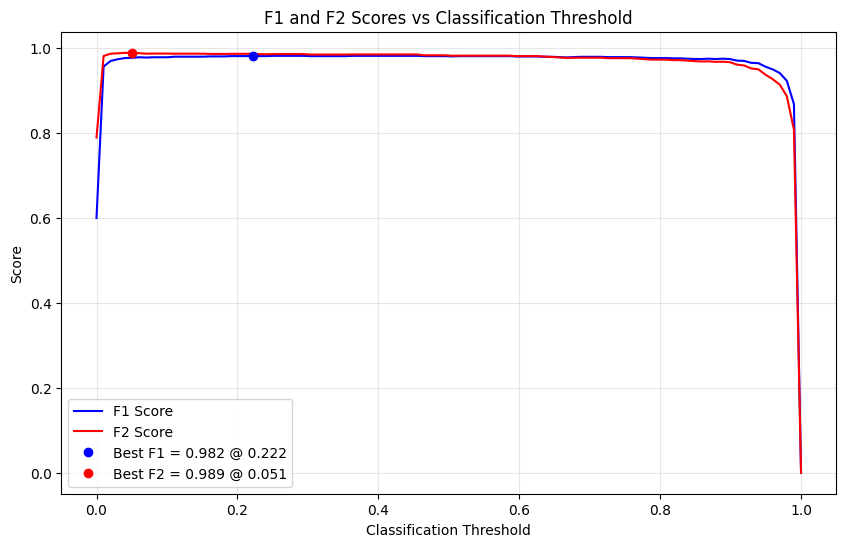

F1: Best score 0.982 at threshold 0.222
F2: Best score 0.989 at threshold 0.051


In [4]:
opt_thresh_f1, opt_thresh_f2, best_f1, best_f2 = plot_threshold_f1f2_curve(
    model=model,
    test_loader=test_loader,
    device=device,
    task=args.task
)

print(f"F1: Best score {best_f1:.3f} at threshold {opt_thresh_f1:.3f}")
print(f"F2: Best score {best_f2:.3f} at threshold {opt_thresh_f2:.3f}")

In [4]:
# Get predictions and overall metrics
metrics, y_true, y_pred, sources = evaluate_model(model, test_loader, threshold=0.222)
print("Overall metrics:", metrics)

Overall metrics: {'accuracy': 0.9842424242424243, 'precision': 0.9735744089012517, 'recall': 0.9900990099009901, 'f1': 0.9817671809256661, 'f2': 0.986749365661122, 'normal_acc': 0.9798515376458112, 'anomaly_acc': 0.9900990099009901}


In [6]:
# Get hydrophone-specific metrics
hydrophone_df = evaluate_by_hydrophone(y_true, y_pred, sources)
display(hydrophone_df)



hydrophone  samples  anomaly_rate  precision    recall  \
0               ICLISTENHF1252        1      1.000000   1.000000  1.000000   
1               ICLISTENHF1253      304      0.000000   1.000000  0.000000   
2               ICLISTENHF1266      228      0.135965   1.000000  0.967742   
3               ICLISTENHF1354      459      0.912854   0.965278  0.995227   
4               ICLISTENHF1951      103      0.330097   0.911765  0.911765   
5               ICLISTENHF6020       83      0.000000   0.000000  0.000000   
6               ICLISTENHF6093       80      0.000000   1.000000  0.000000   
7               ICLISTENHF6094       60      0.000000   1.000000  0.000000   
8               ICLISTENHF6095       97      1.000000   1.000000  1.000000   
9               ICLISTENHF6324      178      0.382022   1.000000  0.985294   
10     JASCOAMARHYDROPHONE2402       21      1.000000   1.000000  1.000000   
11  JASCOAMARHYDROPHONED001022       18      1.000000   1.000000  1.000000   
12  JASCOAMARHYDROPHONEE000186       18      1.000000   1.000000  1.000000   

          f1        f2  num_normal  num_anomaly  pred_normal  pred_anomaly  
0   1.000000  1.000000           0            1            0             1  
1   0.000000  0.000000         304            0          304             0  
2   0.983607  0.974026         197           31          198            30  
3   0.980024  0.989089          40          419           27           432  
4   0.911765  0.911765          69           34           69            34  
5   0.000000  0.000000          83            0           82             1  
6   0.000000  0.000000          80            0           80             0  
7   0.000000  0.000000          60            0           60             0  
8   1.000000  1.000000           0           97            0            97  
9   0.992593  0.988201         110           68          111            67  
10  1.000000  1.000000           0           21            0            21  
11  1.000000  1.000000           0           18            0            18  
12  1.000000  1.000000           0           18            0            18

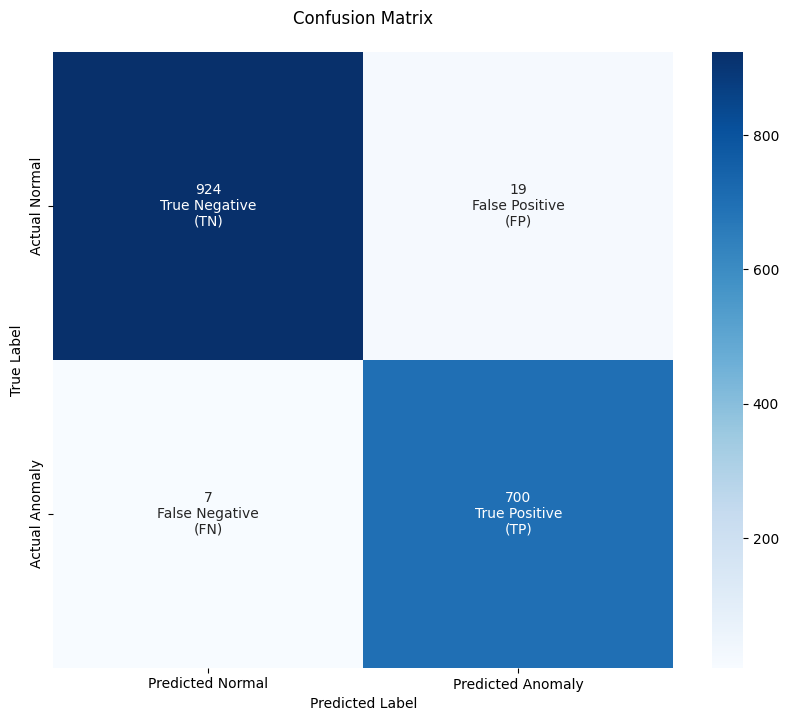

In [9]:
# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred)


Category sizes:
True Positives: 700
True Negatives: 924
False Positives: 19
False Negatives: 7


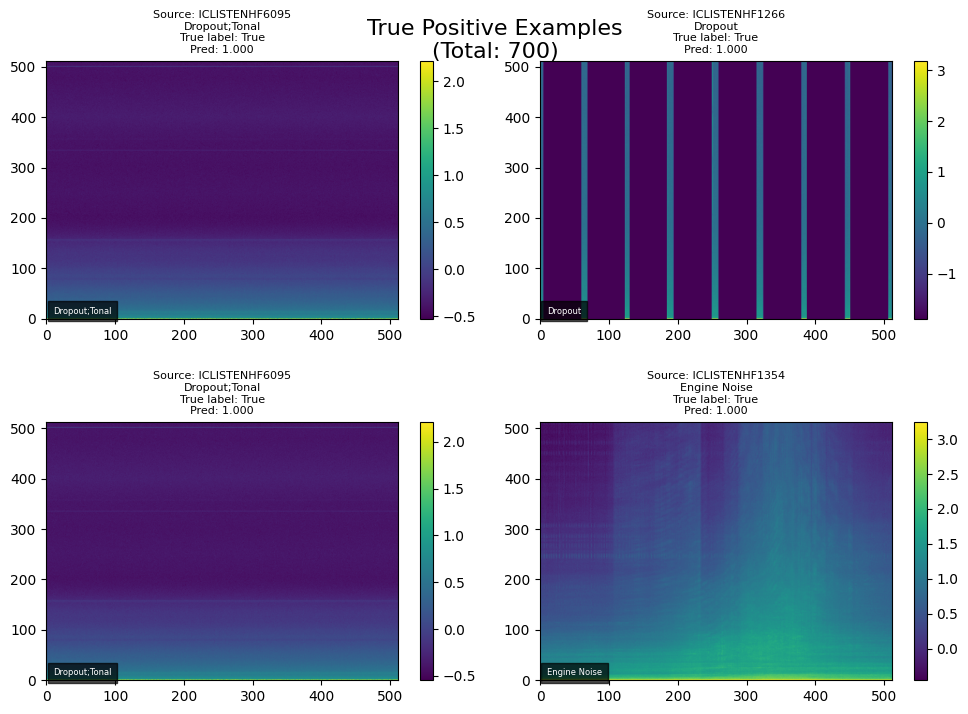

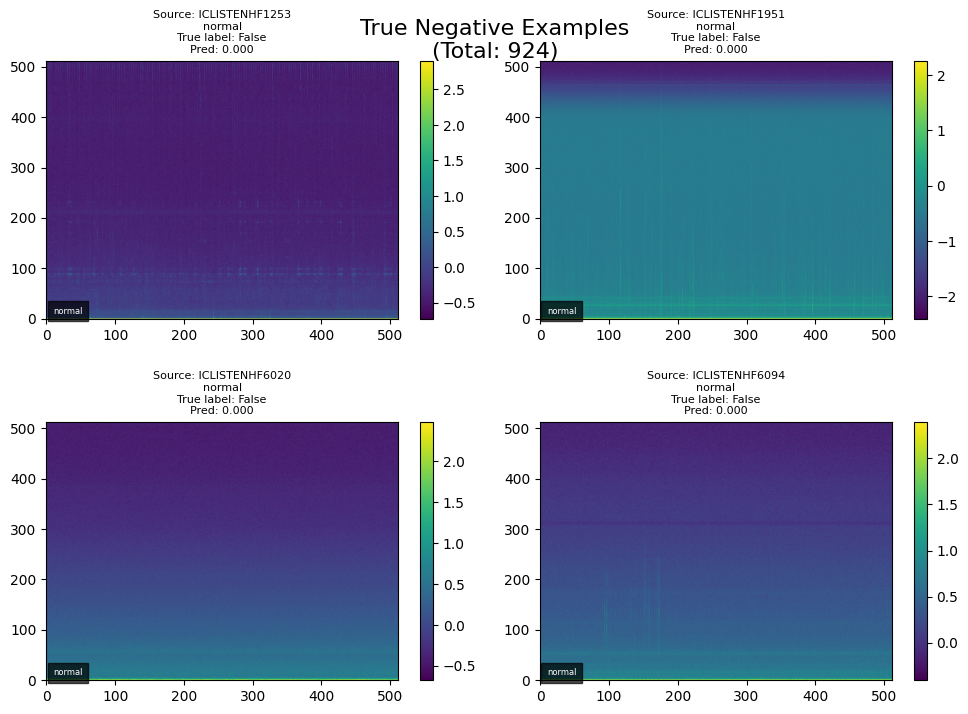

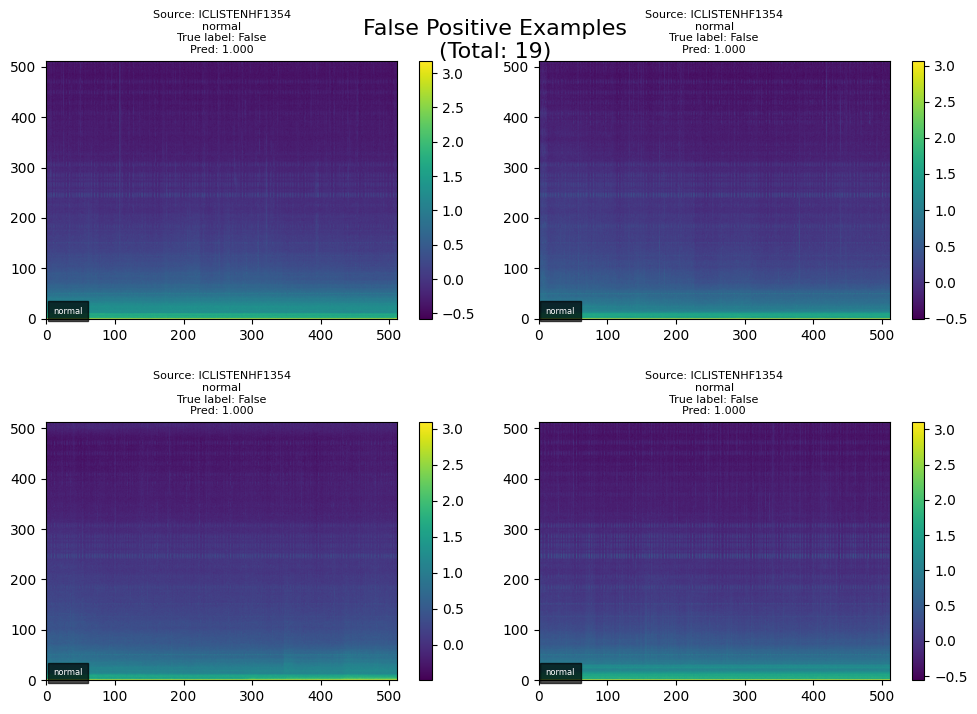

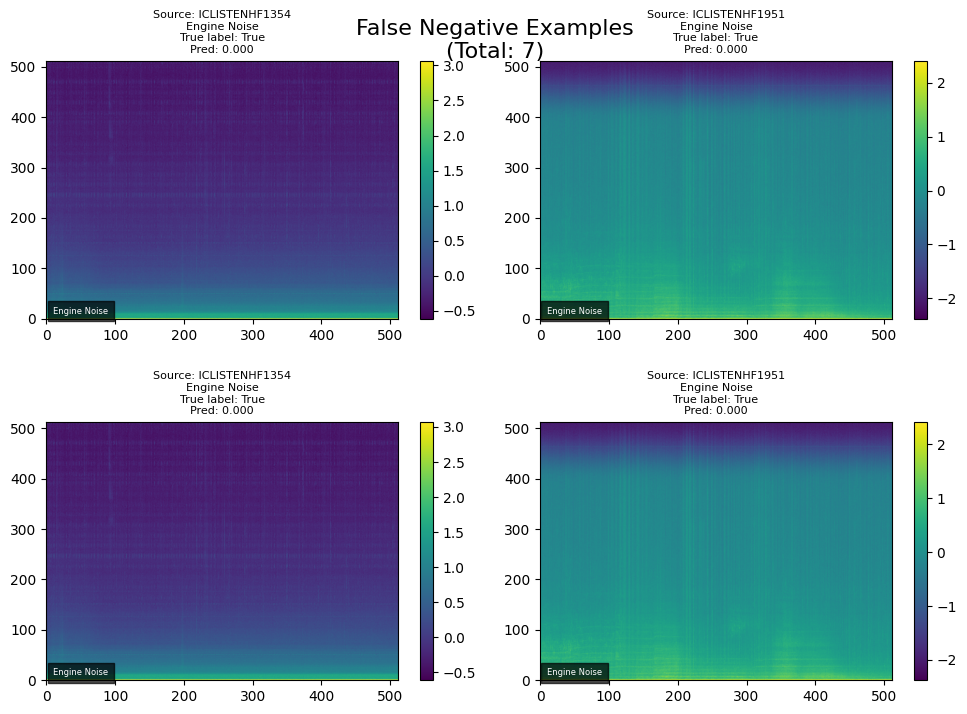

In [10]:
# Show example spectrograms
plot_example_spectrograms(test_dataset, y_pred, num_examples=4, samples_per_row=2)

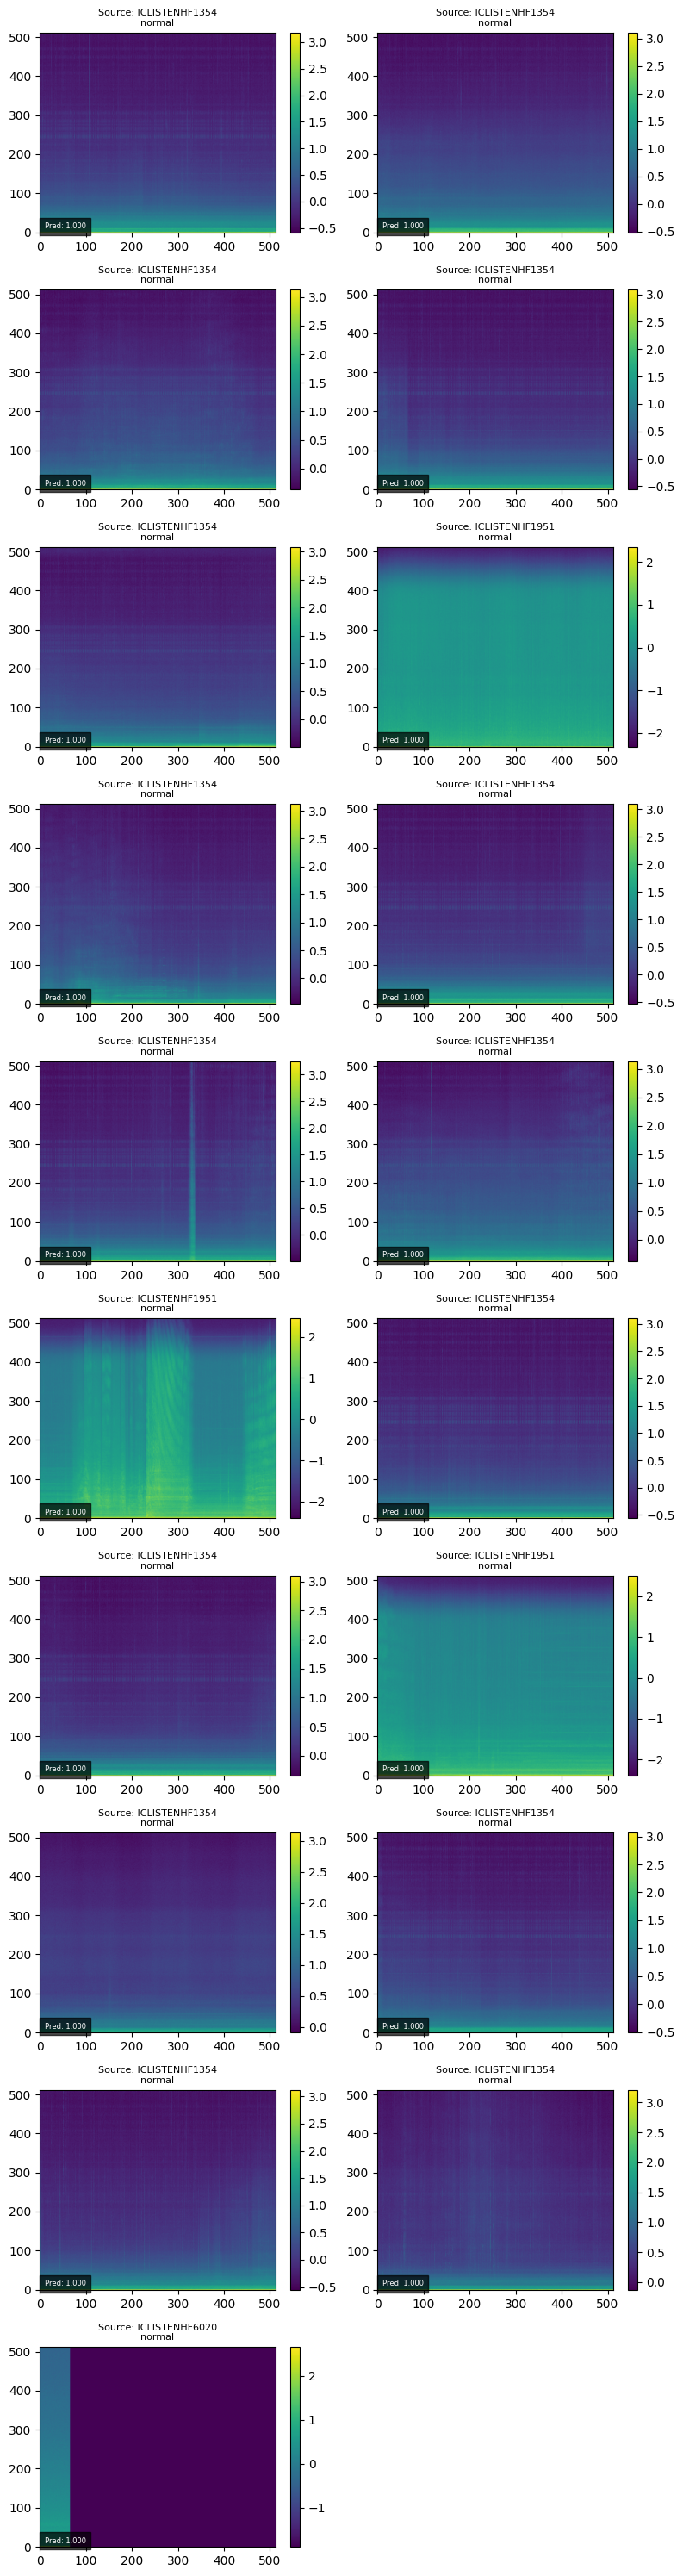

In [12]:
# To see all false positives
plot_all_false_positives(test_dataset, y_pred, samples_per_row=2)

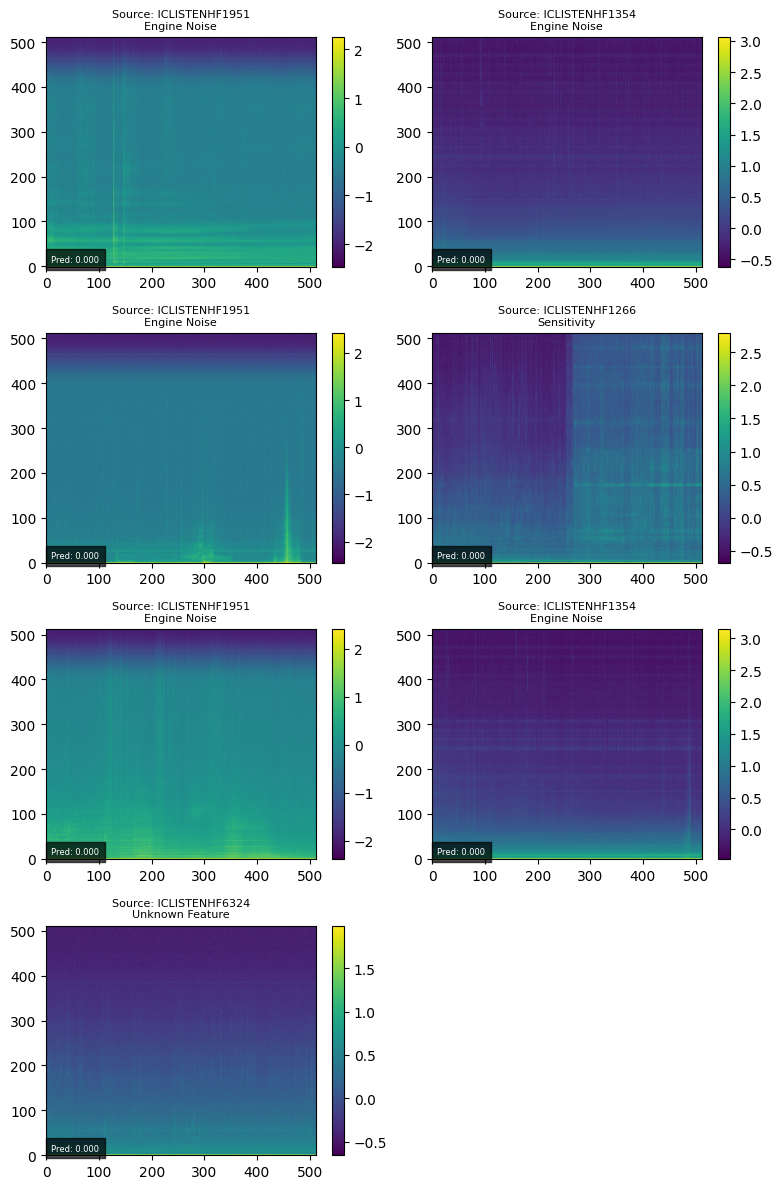

In [13]:
# To see all false negatives
plot_all_false_negatives(test_dataset, y_pred, samples_per_row=2)